In [1]:
import janitor
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('seaborn')

# Load and clean data

In [2]:
# Load station locations data

import geopandas as gpd
import requests
from xml.etree import ElementTree as ET

url = "https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml"

response = requests.get(url)
root = ET.fromstring(response.content)

ids = [int(root[i][0].text) for i in range(0, len(root))]
names = [root[i][1].text for i in range(0, len(root))]
lats = [float(root[i][3].text) for i in range(0, len(root))]
lons = [float(root[i][4].text) for i in range(0, len(root))]
capacities = [int(root[i][12].text) for i in range(0, len(root))]

df = pd.DataFrame(list(zip(ids, names, lats, lons, capacities)),
                        columns=['id', 'name', 'lon', 'lat', 'capacity'])

stations = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lat, df.lon))
stations.crs = {'init' :'epsg:4326'}

print(stations.shape)
stations.head()

(786, 6)


,id,name,lon,lat,capacity,geometry
0,1,"River Street , Clerkenwell",51.529163,-0.109971,19,POINT (-0.10997 51.52916)
1,2,"Phillimore Gardens, Kensington",51.499607,-0.197574,37,POINT (-0.19757 51.49961)
2,3,"Christopher Street, Liverpool Street",51.521284,-0.084606,32,POINT (-0.08461 51.52128)
3,4,"St. Chad's Street, King's Cross",51.530059,-0.120974,23,POINT (-0.12097 51.53006)
4,5,"Sedding Street, Sloane Square",51.493130,-0.156876,27,POINT (-0.15688 51.49313)


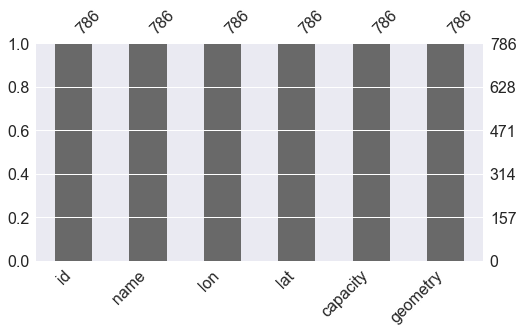

In [3]:
# Check for missings

import missingno as msno
msno.bar(stations, figsize=(8,4));

In [4]:
# Import hires data

hires = (
    pd.read_csv('data/cycle_hires/179JourneyDataExtract11Sep2019-17Sep2019.csv')
    .clean_names()
    .dropna()
    .drop_duplicates()
    .remove_columns(['rental_id', 'duration', 'bike_id'])
    .to_datetime('end_date', format='%d/%m/%Y %H:%M')
    .to_datetime('start_date', format='%d/%m/%Y %H:%M')
)

# Add station capacity

hires = (
    hires
    .merge(stations, left_on='startstation_id', right_on='id')
    .drop(columns=['id', 'name', 'geometry'])
    .rename(columns={'capacity':'startstation_capacity', 
                     'lon':'startstation_lon', 'lat':'startstation_lat'})
)

hires = (
    hires
    .merge(stations, left_on='endstation_id', right_on='id')
    .drop(columns=['id', 'name', 'geometry'])
    .rename(columns={'capacity':'endstation_capacity',
                     'geometry_x':'geometry', 
                     'lon':'endstation_lon', 'lat':'endstation_lat'})
)

print(hires.shape)
hires.head()

(247419, 12)


,end_date,endstation_id,endstation_name,start_date,startstation_id,startstation_name,startstation_lon,startstation_lat,startstation_capacity,endstation_lon,endstation_lat,endstation_capacity
0,2019-09-11 13:25:00,125,"Borough High Street, The Borough",2019-09-11 13:21:00,10,"Park Street, Bankside",51.505974,-0.092754,18,51.500695,-0.094524,21
1,2019-09-12 20:22:00,125,"Borough High Street, The Borough",2019-09-12 19:41:00,10,"Park Street, Bankside",51.505974,-0.092754,18,51.500695,-0.094524,21
2,2019-09-14 12:43:00,125,"Borough High Street, The Borough",2019-09-14 12:16:00,444,"Bethnal Green Garden, Bethnal Green",51.525680,-0.055312,24,51.500695,-0.094524,21
3,2019-09-15 09:47:00,125,"Borough High Street, The Borough",2019-09-15 08:44:00,125,"Borough High Street, The Borough",51.500695,-0.094524,21,51.500695,-0.094524,21
4,2019-09-16 16:11:00,125,"Borough High Street, The Borough",2019-09-16 15:32:00,125,"Borough High Street, The Borough",51.500695,-0.094524,21,51.500695,-0.094524,21


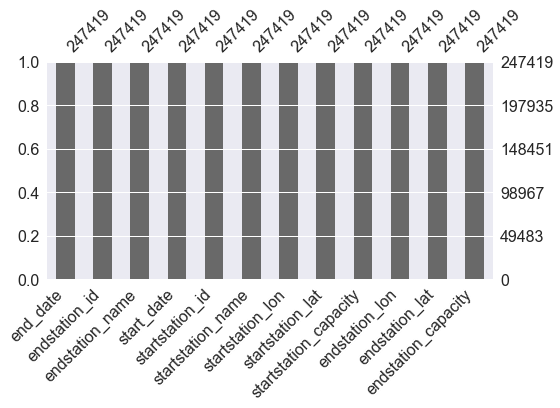

In [5]:
# Check for missings

msno.bar(hires, figsize=(8,4));

# Plot inflows and outflows

In [6]:
# This would probably be a nicer map background, check out.
# buildings = gpd.read_file('data/geo_data/OS OpenMap Local (ESRI Shape File) TQ/TQ_Building.shp')
# From: https://www.ordnancesurvey.co.uk/opendatadownload/products.html#OPROAD

In [7]:
def calc_flows(df):
    """
    Returnes a dataFrame with the number of outgoing
    and incoming bikes for each station.
    """
    outflow = (
        df.groupby('startstation_id')[['start_date']].count()
        .reset_index()
        .rename(columns={'startstation_id':'id', 'start_date':'out'})
    )
    inflow = (
        df.groupby('endstation_id')[['end_date']].count()
        .reset_index()
        .rename(columns={'endstation_id':'id', 'end_date':'in'})
    )
    return outflow.merge(inflow, on='id', how='inner')

# Calculate morning and evening flows on weekdays

weekdays = hires[hires['start_date'].dt.dayofweek < 5]

mornings = weekdays[weekdays['start_date'].dt.hour.between(6,10)]
morning_flows = calc_flows(mornings)
morning_flows = stations.merge(morning_flows, on='id', how='inner')

evenings = weekdays[weekdays['start_date'].dt.hour.between(16,20)]
evening_flows = calc_flows(evenings)
evening_flows = stations.merge(evening_flows, on='id', how='inner')

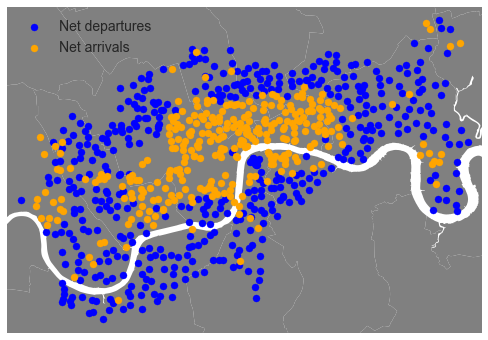

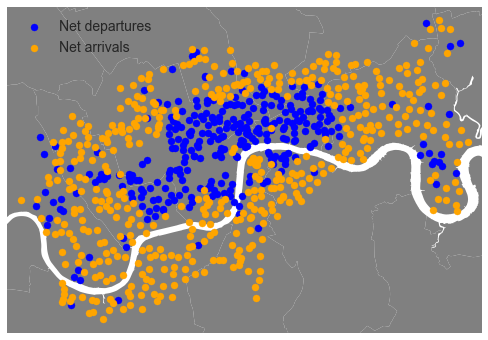

In [8]:
from toolbox.toolbox import get_borough_boundaries

def make_flow_plot(df):
    boundaries = get_borough_boundaries()

    # Ensure crs are consistent
    df = df.to_crs(boundaries.crs)
    
    labels = {True: 'Net departures', False:'Net arrivals'}
    df['net'] = (df['out'] - df['in'] > 0).map(labels)

    fig, ax = plt.subplots(1, 1, figsize=(12,6))

    xmin = df['geometry'].bounds.minx.min() - 500
    xmax = df['geometry'].bounds.maxx.max() + 500
    ymin = df['geometry'].bounds.miny.min() - 500
    ymax = df['geometry'].bounds.maxy.max() + 500

    clist = ['blue', 'orange']
    
    base = boundaries.plot(ax=ax, color='gray')
    for i, v in enumerate(df['net'].unique()):
        df[df['net'] == v].plot(ax=base, marker='o', 
                                c=clist[i], label=v,
                                markersize=50, legend=True)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis('off')
    ax.legend(fontsize=14)

make_flow_plot(morning_flows)
make_flow_plot(evening_flows)

# Commuting patterns

I want to see from where to where people commute. Show usage by thickness of path line.

OSRM request code based on [this](https://github.com/ilkarman/Movement-Visualisations/blob/master/01_TFL_Bikes/py/Bike%20Vis.ipynb) notebook, info on OSRM [here](Following: http://project-osrm.org/docs/v5.22.0/api/?language=cURL#nearest-service)




In [9]:
df = hires.set_index('start_date').loc['16 Sep 2019'].reset_index()
df.head()

,start_date,end_date,endstation_id,endstation_name,startstation_id,startstation_name,startstation_lon,startstation_lat,startstation_capacity,endstation_lon,endstation_lat,endstation_capacity
0,2019-09-16 15:32:00,2019-09-16 16:11:00,125,"Borough High Street, The Borough",125,"Borough High Street, The Borough",51.500695,-0.094524,21,51.500695,-0.094524,21
1,2019-09-16 17:40:00,2019-09-16 18:12:00,125,"Borough High Street, The Borough",125,"Borough High Street, The Borough",51.500695,-0.094524,21,51.500695,-0.094524,21
2,2019-09-16 00:41:00,2019-09-16 01:05:00,125,"Borough High Street, The Borough",125,"Borough High Street, The Borough",51.500695,-0.094524,21,51.500695,-0.094524,21
3,2019-09-16 08:22:00,2019-09-16 08:29:00,125,"Borough High Street, The Borough",272,"Baylis Road, Waterloo",51.501445,-0.110699,22,51.500695,-0.094524,21
4,2019-09-16 10:20:00,2019-09-16 10:27:00,125,"Borough High Street, The Borough",272,"Baylis Road, Waterloo",51.501445,-0.110699,22,51.500695,-0.094524,21


In [10]:
unique_locations = df[['startstation_id',
                       'startstation_lat',
                       'startstation_lon',
                       'endstation_id',
                       'endstation_lat',
                       'endstation_lon']].copy()
print(unique_locations.shape)
unique_locations.drop_duplicates(inplace=True)
print(unique_locations.shape)

(32218, 6)
(24989, 6)


In [11]:
import aiohttp
import asyncio
import json
concurrent = 500

def create_request(row):
    sid, slat, slon, eid, elat, elon = row
    base_url = 'http://router.project-osrm.org/'
    request_url = 'route/v1/bike/{0},{1};{2},{3}'.format(slon, slat, elon, elat)
    options_url = '?alternatives=false&steps=false&geometries=geojson'
    return base_url + request_url + options_url, '%i_%i' % (sid, eid)

# Create list with request for each unique route
requests = unique_locations.apply(create_request, axis=1)
requests.shape

(24989,)

In [12]:
def handle_req(data, qid):
    r = json.loads(data.decode('utf-8'))
    coord = r['routes'][0]['geometry']['coordinates']
        
    dffrom = pd.DataFrame(coord[:-1], columns=['slon', 'slat'])
    dfto = pd.DataFrame(coord[1:], columns=['elon', 'elat'])
    df_journey = pd.concat([dffrom, dfto], axis=1)
    df_journey['route_id'] = qid

    return df_journey

def chunked_http_client(num_chunks, s):
    # Use semaphore to limit number of requests
    semaphore = asyncio.Semaphore(num_chunks)
    @asyncio.coroutine
    # Return co-routine that will work asynchronously and respect
    # locking of semaphore
    def http_get(url, qid):
        nonlocal semaphore
        with (yield from semaphore):
            response = yield from s.get(url)
            body = yield from response.content.read()
            yield from response.wait_for_close()
        return body, qid
    return http_get
 
def run_experiment(urls, _session):
    http_client = chunked_http_client(num_chunks=concurrent, s=_session)
    
    # http_client returns futures, save all the futures to a list
    tasks = [http_client(url, qid) for url, qid in urls]
    
    dfs_route = []
    
    # wait for futures to be ready then iterate over them
    for future in asyncio.as_completed(tasks):
        data, qid = yield from future
        try:
            out = handle_req(data, qid)
            dfs_route.append(out)
        except Exception as err:
            print("Error for {0} - {1}".format(qid, err))
    return dfs_route

In [ ]:
# Run:

async with aiohttp.ClientSession() as session:
    loop = asyncio.get_event_loop()
    calc_routes = loop.run_until_complete(run_experiment(requests, session))


In [14]:
routes_complete = pd.concat(calc_routes, ignore_index=True)

NameError: name 'calc_routes' is not defined

# Misc.

In [ ]:
# Load cycle hire data from website

url = 'https://cycling.data.tfl.gov.uk/usage-stats/'
csv_list = ['179JourneyDataExtract11Sep2019-17Sep2019.csv']

url_list = [url + f for f in csv_list]
df_list = (pd.read_csv(f) for f in url_list)

df = (
    pd.concat(df_list)
#     ...
)

In [ ]:
# Old choropleth graph

# Here, stations seem to be Tube stations, even though they are saved in cycle parking stations file. 

# Load data and combine borough boundaries and profiles

from toolbox.toolbox import get_stations_data
from toolbox.toolbox import get_borough_boundaries
from toolbox.toolbox import get_borough_profiles

stations = get_stations_data()
boundaries = get_borough_boundaries().set_index('name')
profiles = get_borough_profiles().set_index('area_name')

boroughs = boundaries.join(profiles)
boroughs.head()


# Produce graph

import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable

variable = 'population'

# Ensure that maps have the same crs
boroughs = boroughs.to_crs(stations.crs)

# Create borough map as base
fig, ax = plt.subplots(1, 1, figsize=(16,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
base = boroughs.plot(column=variable, cmap='Blues', ax=ax, cax=cax,
                     legend=True, legend_kwds={'label':variable})

# Plot stations on top of base
stations.plot(ax=base, marker='o', color='red', markersize=2)

ax.axis('off')
ax.set_title('Title', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: London Datastore, 2014',xy=(0.1, .08),  
            fontsize=12, color='#555555',
            xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', );

# Inspirations

Based on ideas and code [here](https://github.com/ilkarman/Movement-Visualisations) and [here](https://github.com/charlie1347/TfL_bikes)